In [ ]:
# default_exp data.core_pd

In [ ]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
# hide
from nbdev.showdoc import *

# Data Core

> Using the fastai2 `Datasets` to make an time series dataset.

For now all is univerable but in the future I would also like to add multiplevariable. 


In [ ]:
# export
from fastseq.data.load import *
from fastseq.core import *
from fastcore.all import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *
from fastseq.data.load_pd import *

# Transforms

> Basic function to process time-series data before assembling it in a `DataLoaders`.

## Normalize

### old

In [ ]:
# export
import warnings
class NormalizeTSMulti(ItemTransform):
    "Normalize the Time-Series."
    def __init__(self, to_norm=['TensorCon','TensorSeqs'], verbose=False, make_ones=True, eps=1e-7, mean = None):
        """
        `make_ones` will make the std 1 if the std is smaller than `10*eps`.
        This is for blok seqences to not magnify the `y` part of the data.

        `mean` will set a mean instead of the mean of the x value.
        (
            TensorSeqs(x, label=[self.y_name + '_x'], m=['g']),
            TensorSeqs(tsx,label=self.ts_names),
            TensorCon(cat,label=self.cat_names).long(),
            TensorCon(con,label=self.con_names),
            TensorSeqs(y, label=[self.y_name+ '_y'], m=['r'])
        )
        """
        store_attr(self,'verbose, make_ones, eps, mean,to_norm')
        self.m, self.s = {}, {}
        warnings.warn("NormalizeTSMulti is depricated. Please use `NormalizeSeqsMulti`")

    def encodes(self, o):
        for i in range(len(o)-1):
            self.m[i], self.s[i] = 0, 1
            if type(o[i]) == TensorCon and o[i].shape[-1]>0: # if tensor has shape (bs,0) than ignore
                if 'TensorCon' in self.to_norm:
                    self.m[i] = torch.mean(o[i])
                    self.s[i] = torch.std(o[i]) + self.eps 
            elif type(o[i]) == TensorSeqs:
                if 'TensorSeqs' in self.to_norm:
                    self.m[i] = torch.mean(o[i], -1, keepdim=True)
                    self.s[i] = torch.std(o[i],  -1, keepdim=True) +self.eps
                    self.s[i] = _zeros_2_ones(self.s[i], self.eps*10)
            elif self.verbose:
                if o[i].shape[-1]>0 and not type(o[i]) == TensorCatI:
                    print(f'NormalizeTSMulti:type {type(o[i])} on location:{i}/{len(o)} of tuple not found')
                
        # y must be scaled with m
        self.m[len(o)-1], self.s[len(o)-1] = self.m[0],self.s[0] 
        # TODO make y its own type
        if self.verbose:
            print('encodes',[a.shape for a in o],'m shape', {k:o.shape for k,o in self.m.items()},'s shape',{k:o.shape for k,o in self.s.items()})
        
        return TSMulti_([(o[i]-self.m[i]) / self.s[i] for i in range(len(o))])       
    
    def decodes(self, o):
        if o[0].is_cuda:
            self.m, self.s = to_device(self.m,'cuda'), to_device(self.s,'cuda')
            if sum([a.is_cuda for a in o]) != len(o):
                o = Tuple([to_device(a,'cuda') for a in o])
        else:
            if sum([a.is_cuda==False for a in o]) != len(o):
                o = Tuple([to_cpu(a) for a in o])
            self.m, self.s = to_cpu(self.m), to_cpu(self.s)
        if self.verbose:
            print('decodes',[a.shape for a in o],  {k:o.shape for k,o in self.m.items()},'s shape',{k:o.shape for k,o in self.s.items()})
        return TSMulti_([(o[i]*self.s[i])+self.m[i] for i in range(len(o))])

### new

In [ ]:
# export
def _zeros_2_ones(o, eps=1e-8):
    nan_mask = o!=o
    o[o < eps ] = 1    
    o[nan_mask ] = 1    
    return o
    

In [ ]:
o = np.arange(0,1,.1)
test_close(list(_zeros_2_ones(o,.5)),[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9])

o = np.arange(0,1,.1)[None,:]
test_close(list(_zeros_2_ones(o,.5)),[[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9]])

o = torch.arange(0,1,.1)[None,:]
test_close(_zeros_2_ones(o,.5),tensor([[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9]]))

o = torch.arange(0,1,.1)[None,:]
o[:,-1]= torch.tensor(float('nan'))
test_close(_zeros_2_ones(o,.5),tensor([[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 1]]))

o = np.arange(0,1,.1)[None,:]
o[:,-1]= np.nan
test_close(list(_zeros_2_ones(o,.5)),[[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 1]])

/home/tako/dev/env37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


In [ ]:
a = TensorSeqs(np.arange(12))
a = (a-2)*2.5
a

TensorSeqs([-5.0000, -2.5000,  0.0000,  2.5000,  5.0000,  7.5000, 10.0000, 12.5000,
        15.0000, 17.5000, 20.0000, 22.5000])

In [ ]:
# export
class NormalizeSeqs(Transform):
    def __init__(self, verbose=False, make_ones=True, eps=1e-7, mean = None):
        store_attr(self,'verbose, make_ones, eps, mean')
        self.m, self.s = 0, 1
        
    def to_same_device(self, o):    
        if o.is_cuda:
            self.m, self.s = to_device(self.m,'cuda'), to_device(self.s,'cuda')
        else:
            self.m, self.s = to_cpu(self.m), to_cpu(self.s)     
            
    def encodes(self, o: TensorSeqs):
        self.m = torch.mean(o, -1, keepdim=True)
        self.s = torch.std(o,  -1, keepdim=True) +self.eps
        self.s = _zeros_2_ones(self.s, self.eps*10)
        if self.verbose:
            print('encodes',[a.shape for a in o],
                  'm shape', {k:o.shape for k,o in self.m.items()},
                  's shape',{k:o.shape for k,o in self.s.items()})
        
        return self.norm(o)
    
    def norm(self, o):
        return (o-self.m) / self.s
        
    def decodes(self, o: TensorSeqs):
        if self.verbose:
            print('decodes',o.shape,  
                  'm shape',self.m.shape,
                  's shape',self.s.shape)
        return self.denorm(o)
    
    def denorm(self, o):
        self.to_same_device(o)
        return (o*self.s)+self.m 

In [ ]:
tmf = NormalizeSeqs()
o = TensorSeqs(np.arange(12.))
o_tmf = tmf(o)
test_eq(tmf.decode(o_tmf),TensorSeqs(np.arange(12.)))

In [ ]:
# export
class NormalizeSeqsMulti(ItemTransform):
    """A shell Transformer to normalize `TensorSeqs` inside `TSMulti_` with `NormalizeSeqs`. """
    @delegates(NormalizeSeqs.__init__)
    def __init__(self, n_its=4, **kwargs):
        """`n_its` does not include the ts to predict."""
        self.f = {i:NormalizeSeqs(**kwargs) for i in range(n_its)}
        
    def encodes(self, o:TSMulti_):
        r = L(self.f[i](a) for i,a in enumerate(o[:-1]))
        r.append(self.f[0].norm(o[-1]))
        return TSMulti_(r)
    
    def decodes(self, o:TSMulti_): 
        r = L(self.f[i].decode(a) for i,a in enumerate(o[:-1]))
        r.append(self.f[0].denorm(o[-1]))
        return TSMulti_(r)
    

In [ ]:
o = TSMulti_(TensorSeqs(np.arange(12.)),1,2,TensorSeqs(np.arange(-1,11.)))
tmf = NormalizeSeqsMulti(len(o))
o_tmf = tmf(o)
test_close(o_tmf[0].mean(),0);test_close(o_tmf[0].std(),1);
test_eq(o_tmf[1],1)
test_eq(o_tmf[2],2)
# Note the y has not mean 0 because it is normalized with the stats of the first item in the tuple
test_close(o_tmf[3].mean(),-0.27,.1); test_close(o_tmf[3].std(),1); 
test_eq(tmf.decode(o_tmf), o)

In [ ]:
from fastseq.data.load import *
horizon,lookback = 2,5
def get_df():
    t = np.arange(-5,5.)
    a = np.sin(t)
    return pd.DataFrame({'x':[i + (i*.6)*a*-.5 for i in range(1,5)],
                   'a':[i+a for i in range(1,5)],
                   'b':[i+torch.randn(1).numpy()[0] for i in range(1,5)],
                   'cat':[i for i in 'aabb'],                  
                  })
df = get_df()
df

x  \
0  [0.7123227176010585, 0.7729592514076216, 1.0423360024179602, 1.2727892280477044, 1.252441295442369, 1.0, 0.7475587045576311, 0.7272107719522956, 0.9576639975820398, 1.2270407485923784]   
1      [1.424645435202117, 1.5459185028152431, 2.0846720048359204, 2.545578456095409, 2.504882590884738, 2.0, 1.4951174091152621, 1.454421543904591, 1.9153279951640796, 2.454081497184757]   
2   [2.1369681528031754, 2.3188777542228647, 3.1270080072538806, 3.8183676841431136, 3.757323886327107, 3.0, 2.242676113672893, 2.1816323158568864, 2.8729919927461194, 3.6811222457771353]   
3        [2.849290870404234, 3.0918370056304862, 4.169344009671841, 5.091156912190818, 5.009765181769476, 4.0, 2.9902348182305243, 2.908843087809182, 3.830655990328159, 4.908162994369514]   

                                                                                                                                                                                            a  \
0  [1.9589242746631386, 1.7568024953079282, 0.8588799919401328, 0.09070257317431829, 0.1585290151921035, 1.0, 1.8414709848078965, 1.9092974268256817, 1.1411200080598671, 0.2431975046920718]   
1    [2.9589242746631386, 2.7568024953079284, 1.8588799919401329, 1.0907025731743183, 1.1585290151921035, 2.0, 2.8414709848078967, 2.909297426825682, 2.1411200080598674, 1.2431975046920718]   
2     [3.9589242746631386, 3.7568024953079284, 2.8588799919401326, 2.090702573174318, 2.1585290151921033, 3.0, 3.8414709848078967, 3.909297426825682, 3.1411200080598674, 2.2431975046920716]   
3         [4.958924274663138, 4.756802495307928, 3.8588799919401326, 3.090702573174318, 3.1585290151921033, 4.0, 4.841470984807897, 4.909297426825682, 4.141120008059867, 3.2431975046920716]   

          b cat  
0  1.036688   a  
1  3.113937   a  
2  3.104885   b  
3  3.266472   b

In [ ]:
df

x  \
0  [0.7123227176010585, 0.7729592514076216, 1.0423360024179602, 1.2727892280477044, 1.252441295442369, 1.0, 0.7475587045576311, 0.7272107719522956, 0.9576639975820398, 1.2270407485923784]   
1      [1.424645435202117, 1.5459185028152431, 2.0846720048359204, 2.545578456095409, 2.504882590884738, 2.0, 1.4951174091152621, 1.454421543904591, 1.9153279951640796, 2.454081497184757]   
2   [2.1369681528031754, 2.3188777542228647, 3.1270080072538806, 3.8183676841431136, 3.757323886327107, 3.0, 2.242676113672893, 2.1816323158568864, 2.8729919927461194, 3.6811222457771353]   
3        [2.849290870404234, 3.0918370056304862, 4.169344009671841, 5.091156912190818, 5.009765181769476, 4.0, 2.9902348182305243, 2.908843087809182, 3.830655990328159, 4.908162994369514]   

                                                                                                                                                                                            a  \
0  [1.9589242746631386, 1.7568024953079282, 0.8588799919401328, 0.09070257317431829, 0.1585290151921035, 1.0, 1.8414709848078965, 1.9092974268256817, 1.1411200080598671, 0.2431975046920718]   
1    [2.9589242746631386, 2.7568024953079284, 1.8588799919401329, 1.0907025731743183, 1.1585290151921035, 2.0, 2.8414709848078967, 2.909297426825682, 2.1411200080598674, 1.2431975046920718]   
2     [3.9589242746631386, 3.7568024953079284, 2.8588799919401326, 2.090702573174318, 2.1585290151921033, 3.0, 3.8414709848078967, 3.909297426825682, 3.1411200080598674, 2.2431975046920716]   
3         [4.958924274663138, 4.756802495307928, 3.8588799919401326, 3.090702573174318, 3.1585290151921033, 4.0, 4.841470984807897, 4.909297426825682, 4.141120008059867, 3.2431975046920716]   

          b cat  
0  1.036688   a  
1  3.113937   a  
2  3.104885   b  
3  3.266472   b

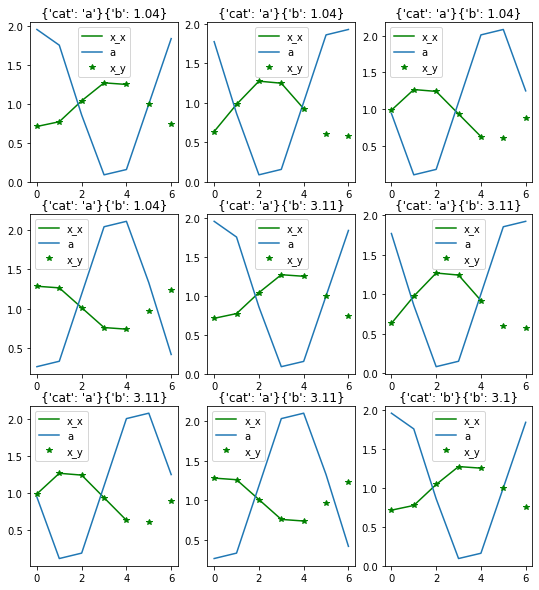

In [ ]:
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, 
                  after_batch = NormalizeSeqsMulti(),
                  num_workers = 0)
dl.show_batch()

In [ ]:
# hide
for o in dl:
    for a in o[:-1]:
        if a.shape[-1] > 0 and type(a) is TensorSeqs:
            test_close(a.mean(),0)
            test_close(a.std(),1,.1)
    test_close(o[0][:,:,:lookback],o[-1][:,:,:lookback],.1)
    test_eq(type(o),TSMulti_)
    o_new = dl.after_batch[0].decode(o)
    test_eq(o_new[0].mean()!=0, True)
    test_eq(o_new[0].std()!=1, True)
    break
    
test_eq(type(dl.one_batch()), TSMulti_)

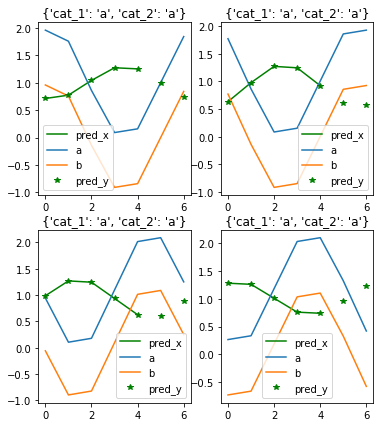

In [ ]:
# hide
# basic
from fastseq.data.load import *
horizon,lookback = 2,5
t = np.arange(-5,5.)
a = np.sin(t)
df = pd.DataFrame({'pred':[i + (i*.6)*a*-.5 for i in range(1,5)],'a':[i+a for i in range(1,5)],'b':[a for _ in range(1,5)],
                  'cat_1':[i for i in 'abbc'],'cat_2':[i for i in 'aabb']})
dl = DfDataLoader(df,'pred', horizon = horizon, lookback = lookback,after_batch=NormalizeSeqsMulti(),
                  num_workers = 1)
for o in dl:
    for a in o[:-1]:
        for i in range(a.shape[0]):
            if a.shape[-1]>0 and type(a) is not TensorCatI:
                test_close(a[i].mean(),0)
                test_close(a[i].std(),1,.1)
    test_close(o[0][:,:,:lookback],o[-1][:,:,:lookback],.1)
    test_eq(type(o),TSMulti_)
    o_new = dl.after_batch[0].decode(o)
    test_eq(o_new[0].mean()!=0, True)
    test_eq(o_new[0].std()!=1, True)
    break
    
test_eq(type(dl.one_batch()),TSMulti_)

dl.show_batch(max_n = 4)

# TSDataLoaders

## Utils

In [ ]:
def concat_ts_list(train, val):
    items=L()
    assert len(train) == len(val)
    for t, v in zip(train, val):
        items.append(np.concatenate([t,v],1))
    return items

In [ ]:
a = [np.random.randn(3,10)]*50
b = [np.random.randn(3,5)]*50
r = concat_ts_list(a,b)
test_eq(r[0].shape,(3,15))
test_eq(r[0], np.concatenate([a[0],b[0]],1))

In [ ]:
# export
def make_test_df(df:L(), horizon:int, lookback:int, keep_lookback:bool = False):
    """Splits the series in `df` based on `horizon + lookback`*, where the last part will go into `val` and the first in `train`.

    *if `keep_lookback`:
        it will only remove `horizon` from `train` otherwise also lookback.
    """
    train, val = {}, {}  
    for col in df:
        train[col], val[col] = [], []        
        if type(df.loc[0, col])==pd.Series or type(df.loc[0, col]) == np.ndarray:
            for row in df[col]:
                val[col].append(row.flatten()[-(horizon+lookback):])
                if keep_lookback:
                    train[col].append(row.flatten()[:-(horizon)])
                else:
                    train[col].append(row.flatten()[:-(horizon+lookback)])
        else:
            val[col]   = df[col]
            train[col] = df[col]

    return pd.DataFrame(train), pd.DataFrame(val)


In [ ]:
# hide
from fastseq.data.external import *
horizon,lookback = 5,10
df = dummy_data_generator_multi(70)
train, val = make_test_df(df, 5, 2)
test_eq(train.loc[0,'x'].shape, (63,))
train.head()

x  \
0  [2.7121891244977454, 2.5486597063311485, 2.0906930671430755, 1.8115814062859135, 1.5183393742579416, 1.3208252232128055, 1.0896407773752452, 0.8603821411445777, 0.6386616357700954, 0.6351340483338248, 0.48743148872033853, 0.4428026662860138, 0.3420585133322473, 0.46952919368379253, 0.2903368578702446, 0.26012809181479307, 0.366458149826647, 0.34534621161900164, 0.38031564261590317, 0.43126867064749747, 0.4823142785958689, 0.5143497702517588, 0.41152099093488936, 0.5117586556092593, 0.5910593704631164, 0.5035997383091033, 0.47733281576151204, 0.497174946272697, 0.4571004415710987, 0.3608970...   
1  [-2.4536659142221238, -2.181126944351321, -2.047497687026687, -1.8938884562865557, -1.7124844579521208, -1.489877033460574, -1.266272317147641, -1.1097861614880313, -0.8539482642576249, -0.7132442347721172, -0.6435889006668698, -0.4888390326576154, -0.325068422710418, -0.2406681565162698, -0.24750081911381483, -0.16036216821788338, -0.26861149917367105, -0.1971558522777963, -0.2841143115214594, -0.2875475395874707, -0.3533241767758591, -0.3671919297175908, -0.3151040542550006, -0.3878778882590043, -0.33573384514289717, -0.5098652837346141, -0.4199957910663169, -0.4692174439514301, -0.58096...   
2  [2.3310361845748875, 1.5667097209414431, 1.2585212316661623, 0.44456232518852806, 0.19124753608202777, 0.24675416362821617, 0.18154674951105704, -0.11838870981043546, -0.02098326119115955, 0.01462039589356804, -0.03294450055453915, 0.25419118404684465, 0.27259863256714684, 0.15430685615202008, 0.16225638379217852, 0.6354050127648059, 0.7319792627079182, 0.666550621788415, 0.725112249996179, 0.7846018395886355, 0.930882314676937, 0.4113843563560684, -0.017956772463268614, -0.19456771698110828, -0.4116158500789099, -0.4114546733463951, -0.7946735873277604, -0.5427477254881315, -0.74144174235...   
3  [1.7776797303936551, 1.6694917246316867, 1.5129085686022712, 1.4173390331536926, 1.4429860288130119, 1.4745319154625387, 1.274625388882253, 1.2842254793685526, 1.4119454671613543, 1.3345575689872426, 1.2941089036530988, 1.3882434376267296, 1.3964902884189947, 1.272563177676582, 1.4031874968912705, 1.4005666091925726, 1.2778900895086758, 1.1661514327692581, 1.0609515516714056, 0.9713390111042118, 0.6510615216710559, 0.5926066215639675, 0.47597018098992766, 0.40177356670542336, 0.15363038114931465, 0.11245304337110382, 0.014024310194191038, -0.0028755269918306656, -0.01224117450218733, -0.02...   
4  [-2.432250470036207, -2.3370447519026794, -2.210662501397593, -1.9625577598924397, -1.807037934142162, -1.6916288494771072, -1.556923384842202, -1.2942717399750046, -1.166880510934721, -1.058563164558884, -0.9277053940960415, -0.6446821964120866, -0.6630103583966189, -0.504516367842098, -0.3701610302154662, -0.42538235006026864, -0.3930034495324843, -0.2919101236205207, -0.3267139743247192, -0.38757405548498486, -0.3043405114607082, -0.3622322889653773, -0.23880155446601214, -0.16421340994897143, -0.15746666481734245, -0.21271658763430587, -0.08102043602285747, 0.019011355399428796, 0.0596...   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   weather  \
0  [0.4445334975733056, 0.4692179678348506, 0.4716765980039832, 0.4570442687645494, 0.4330854789567804, 0.40911735663458537, 0.39471299985120045, 0.3983615734484386, 0.42626772384281064, 0.48145429900345016, 0.5632915759283825, 0.6675187051060822, 0.7867566416969325, 0.9114454182850442, 1.031081194989464, 1.1355878579716958, 1.2166395250005002, 1.268756651

In [ ]:
a = pd.DataFrame({'a':[np.arange(0,15)]*50,'b':[np.arange(0,15)]*50, 'c':[3]*50})
train, val = make_test_df(a,5,2)
test_eq(train['a'][0].max(),7)
test_eq(val['a'][0].min(),8)
test_eq(val['c'][0],val['c'][1])
train.head(), val.head()

(                          a                         b  c
 0  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 1  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 2  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 3  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 4  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3,
                             a                           b  c
 0  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 1  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 2  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 3  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 4  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3)

In [ ]:
# hide
train, val = make_test_df(a,5,2,True)
test_eq(train['a'][0].max(),9)
test_eq(val['a'][0].min(),8)
test_eq(val['c'][0],val['c'][1])
train.head(), val.head()

(                                a                               b  c
 0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3,
                             a                           b  c
 0  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 1  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 2  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 3  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 4  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3)

## Dataloaders

In [ ]:
#export
class DfDataLoaders(DataLoaders):
    @classmethod
    @delegates(DfDataLoader.__init__)
    def from_df(cls, dataset:pd.DataFrame, y_name:str, horizon:int, valid_pct=1.5, seed=None, lookback=None, step=1,
                   incl_test = True, path:Path='.', device=None, norm=True, **kwargs):
        """Create an list of time series.
        The `DataLoader` for the test set will be save as an attribute under `test`
        """
        lookback = ifnone(lookback, horizon * 4)
        device = ifnone(device, default_device())
        if incl_test:
            dataset, test = make_test_df(dataset, horizon, lookback, keep_lookback = True)
        train, valid = make_test_df(dataset, horizon + int(valid_pct*horizon), lookback , keep_lookback = True)
        if norm and 'after_batch' not in kwargs:
            kwargs.update({'after_batch':L(NormalizeSeqsMulti(n_its=4))})
        db = DataLoaders(*[DfDataLoader(ds, y_name, horizon=horizon, lookback=lookback, step=step, device=device, norm = False, **kwargs)
                           for ds in [train,valid]], path=path, device=device)
        if incl_test:
            db.test = DfDataLoader(test, y_name, horizon=horizon, lookback=lookback, step=step, name='test', device=device, **kwargs)

            print(f"Train:{db.train.n}; Valid: {db.valid.n}; Test {db.test.n}")
        else:
            print(f"Train:{db.train.n}; Valid: {db.valid.n}")

        return db

In [ ]:
# hide
# device `cpu`
horizon,lookback = 2,5
t = np.arange(-5,25)
a = np.sin(t)
df = pd.DataFrame({'pred':[i + (i*.6)*a*-.5 for i in range(1,100)],'a':[i+a for i in range(1,100)]})


In [ ]:
# hide
data = DfDataLoaders.from_df(df, 'pred', horizon = horizon, lookback=lookback, step=5, device = torch.device('cpu'))
test_eq(data.valid.dataset.iloc[0,0].shape[-1],data.valid.dataset.iloc[0,1].shape[-1])
test_eq(data.valid.dataset.iloc[0,0].shape[-1]>lookback+horizon, True)
test_eq(hasattr(data,'test'),True)
test_eq([o[0].device for o in data.train][0], torch.device('cpu'))
test_eq([o[0].device for o in data.test][0], torch.device('cpu'))

Train:396; Valid: 99; Test 99


In [ ]:
# hide
# default device

data = DfDataLoaders.from_df(df,'pred', horizon = horizon, lookback=lookback, step=5)
test_eq(data.valid.dataset.iloc[0,0].shape[-1]>lookback+horizon, True)
test_eq(hasattr(data,'test'),True)
test_eq([o[0].device for o in data.train][0], default_device())
test_eq([o[0].device for o in data.test][0], default_device())

Train:396; Valid: 99; Test 99


In [ ]:
# hide
dbunch = DfDataLoaders.from_df(df,'pred',horizon=horizon, lookback = lookback, incl_test=False)
test_eq(hasattr(dbunch,'test'),False)

Train:1881; Valid: 396


In [ ]:
show_doc(DfDataLoaders.from_df, name='DfDataLoaders.from_df')

<h4 id="DfDataLoaders.from_df" class="doc_header"><code>DfDataLoaders.from_df</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>DfDataLoaders.from_df</code>(**`dataset`**:`DataFrame`, **`y_name`**:`str`, **`horizon`**:`int`, **`valid_pct`**=*`1.5`*, **`seed`**=*`None`*, **`lookback`**=*`None`*, **`step`**=*`1`*, **`incl_test`**=*`True`*, **`path`**:`Path`=*`'.'`*, **`device`**=*`None`*, **`norm`**=*`True`*, **`min_seq_len`**=*`None`*, **`max_std`**=*`None`*, **`bs`**=*`64`*, **`shuffle`**=*`False`*, **`num_workers`**=*`None`*, **`verbose`**=*`False`*, **`do_setup`**=*`True`*, **`pin_memory`**=*`False`*, **`timeout`**=*`0`*, **`batch_size`**=*`None`*, **`drop_last`**=*`False`*, **`indexed`**=*`None`*, **`n`**=*`None`*, **`wif`**=*`None`*, **`before_iter`**=*`None`*, **`after_item`**=*`None`*, **`before_batch`**=*`None`*, **`after_batch`**=*`None`*, **`after_iter`**=*`None`*, **`create_batches`**=*`None`*, **`create_item`**=*`None`*, **`create_batch`**=*`None`*, **`retain`**=*`None`*, **`get_idxs`**=*`None`*, **`sample`**=*`None`*, **`shuffle_fn`**=*`None`*, **`do_batch`**=*`None`*)

Create an list of time series.
The `DataLoader` for the test set will be save as an attribute under `test`

In [ ]:
from fastseq.data.external import *
horizon,lookback = 5,10
df = dummy_data_generator_multi(70)
df.head(3)

x  \
0  [[-1.9280703313350809, -1.7654360046963449, -1.6583371701519745, -1.44902469614356, -1.45593697080852, -1.3781416332326821, -1.1957683399436325, -1.2619447970024666, -1.163130815949351, -1.0311998226621504, -0.9453414246695043, -0.7616946440047914, -0.4418111743201796, -0.2782197365823023, 0.046794949575128995, 0.12435108679217158, 0.34268443024305373, 0.4234322886829598, 0.7180507889322683, 0.6934295525000584, 0.736658542137866, 0.8672443281472818, 0.9506134294408065, 0.9036413746923178, 0.9144354537466015, 0.8692194152903736, 0.8323542935401093, 0.6822716016408654, 0.5894906420424152, 0....   
1  [[2.346377781218191, 2.099581724605805, 1.9604000376857211, 1.7284640785948193, 1.6230111601372983, 1.4112403994772214, 1.3221422534009164, 1.2908141871649328, 1.127476501865916, 1.07751468191726, 0.9721899732652, 0.858379472860562, 0.799937468884083, 0.725370109456978, 0.5877854930605255, 0.6619279885419064, 0.6326831291463919, 0.6140848463593174, 0.716310961715234, 0.7208035966823753, 0.7610109927157341, 0.7740059105237304, 0.6677435163169599, 0.6430189502771139, 0.5507778448035877, 0.43585509426561, 0.34795543248664945, 0.31608261319430864, 0.18528327269960948, 0.17762996077379636, 0.11...   
2  [[1.5787290884032879, 1.4080862132766219, 1.096127380126186, 1.2444181408779775, 0.8203446526564172, 1.138930373765054, 0.8736606208569647, 0.9847796790445544, 0.7079264436386995, 0.8376603949882008, 0.8014232804140813, 0.4303789891958993, 0.9034451160796213, 0.9106998651469146, 0.5121259561311597, 0.8770135741731641, 0.6602200201946788, 0.415407332880955, 0.5320628458059822, 0.742610761370253, 0.7261504627687754, 0.8752232901782172, 1.025432100260024, 0.9730940291669512, 0.9674525730245304, 1.0843858671001094, 0.8396078412799894, 0.7443426772855978, 0.6975644068123085, 0.8239752579517555,...   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   weather  \
0  [[10.767737300400597, 10.489192960692822, 10.092047626811945, 9.645886141173534, 9.22567076086421, 8.901048917862722, 8.726440435689833, 8.733260227457613, 8.925341404557038, 9.278188309023061, 9.742168159710966, 10.249214234414634, 10.722135286038458, 11.085269932950188, 11.275039281045276, 11.248961208932496, 10.991894325560303, 10.518651070559452, 9.87260769521859, 9.120478064596668, 8.343935585577716, 7.629193243729981, 7.0559282334611515, 6.687027623138604, 6.560522711270845, 6.684786822125835, 7.037633726591817, 7.569430643524099, 8.209801421863354, 8.87701460163685, 9.48879241581585...   
1  [[8.405964107784385, 8.08797722564996, 7.659710800252538, 7.302000431268692, 7.16450196088606, 7.3155047336839685, 7.718652648407562, 8.243868356661956, 8.709130871158136, 8.940128126712324, 8.829130642155922, 8.374454098750356, 7.687619645466579, 6.965071296078269, 6.432138927665992, 6.275570328561995, 6.584766160120132, 7.319643603740462, 8.31543498674653, 9.323930535560008, 10.07989736845844, 10.373858777218478, 10.110360106673621, 9.334916528662282, 8.221851860099568, 7.026545223979166, 6.01587106565621, 5.3968244285883955, 5.2636520116856, 5.578190801681605, 6.188243253322849, 6.87763...   
2  [[9.592091337842973, 9.387097720526167, 9.09431483230549, 8.757122072446052, 8.433161006530764, 8.176983378635834, 8.023594967139937, 7.977828873723223, 8.012736417623577, 8.077483160081215, 8.112390703981552, 8.066624610564835, 7.91323619906894, 7.657058571174005, 7.333097505258713, 6.995904745399259, 6.703121857178614, 6.498128239861804, 6.39699423506

Train:130; Valid: 60; Test 10


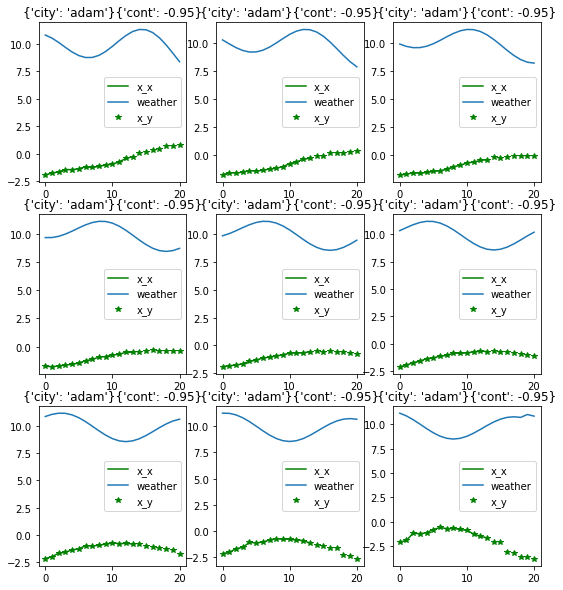

In [ ]:
dbunch =  DfDataLoaders.from_df(df, 'x', horizon = 7, lookback=14, step=2, bs=32)
dbunch.train.show_batch(max_n=9)

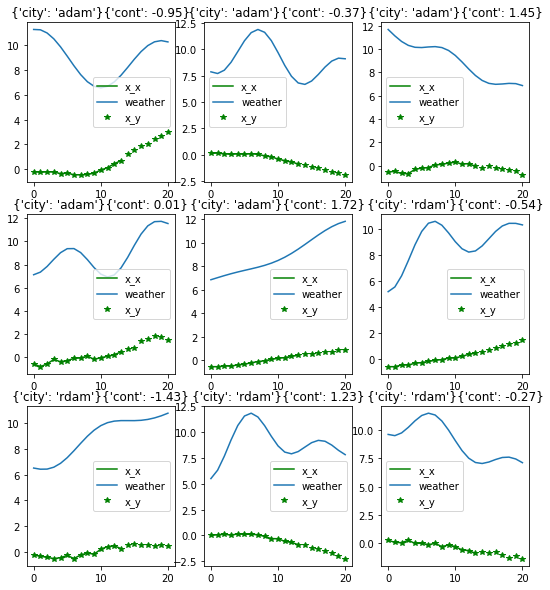

In [ ]:
dbunch.test.show_batch(max_n=9)

## M5

In [ ]:
path = Path('../data/m5')
path.ls()

(#8) [Path('../data/m5/sales_train_validation.csv'),Path('../data/m5/M5-Competitors-Guide_Final-1.pdf'),Path('../data/m5/sample_submission.csv'),Path('../data/m5/Screenshot from 2020-03-04 13-24-55.png'),Path('../data/m5/calendar.csv'),Path('../data/m5/m5-forecasting-accuracy.zip'),Path('../data/m5/Screenshot from 2020-03-04 13-25-42.png'),Path('../data/m5/sell_prices.csv')]

In [ ]:
df_sales = pd.read_csv(path / 'sales_train_validation.csv',).iloc[:100,:]
df_sales.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0    0  ...       2       1       1       0       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       3       0       1       1  
1       1       0       0       0       0  
2       1       0       1       1       1  
3       0       1       3       7       2  
4       1       2       2       2       4  

[5 rows x 1919 columns]

In [ ]:
def _to_series(df):
    r = []
    for i in range(df.shape[0]):
        r.append(pd.Series(df.iloc[i,6:].values.astype(float)))
    return r

def to_contained_series(df):    
    data={k:v for k,v in dict(df).items() if 'd_' not in k}
    data['sales'] = pd.Series(_to_series(df))
    df = pd.DataFrame(data=data)
    return df
df_sales_s = to_contained_series(df_sales)

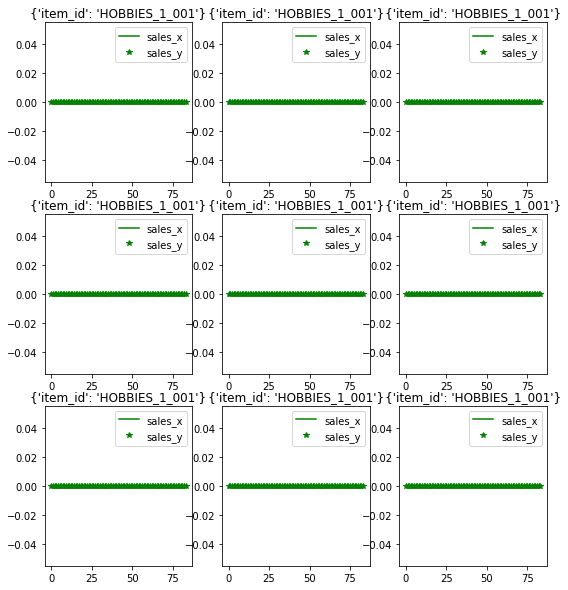

In [ ]:
dl =  DfDataLoader(df_sales_s.loc[:,['sales','item_id']], 'sales', horizon = 28, lookback=28*2, step=7)
dl.show_batch(max_n=9)

In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 020_data.load_pd.ipynb.
Converted 02_data.load.ipynb.
Converted 030_data.core_pd.ipynb.
Converted 03_data.core.ipynb.
Converted 050_nbeats.models_multi.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 06_nbeats.callbacks.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
